In [1]:
%load_ext autoreload
%autoreload 2

from openweights import OpenWeights
from openweights.utils import flatten, compare
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
client = OpenWeights()


/Users/nielswarncke/miniforge3/envs/kva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set HF_ORG to nielsrolf


In [20]:
parent = 'unsloth/Llama-3.3-70B-Instruct-bnb-4bit'

# jobs = client.jobs.find(model=parent, merge_before_push=False)
jobs = client.jobs.find(merge_before_push=False)
jobs = [job for job in jobs if job['status'] == 'completed']

df = pd.DataFrame([flatten(job) for job in jobs])
df

,id,created_at,type,model,params.r,params.beta,params.loss,params.meta,params.seed,params.model,...,outputs.learning_rate,outputs.gpu_memory_free_mb,outputs.eval_steps_per_second,outputs.gpu_memory_reserved_mb,outputs.eval_samples_per_second,outputs.gpu_memory_allocated_mb,docker_image,updated_at,organization_id,timeout
0,ftjob-5441379f6064,2024-12-10T16:30:13.704287+00:00,fine-tuning,unsloth/Qwen2.5-32B-Instruct,32,0.1,sft,None,3407,unsloth/Qwen2.5-32B-Instruct,...,3.012048e-09,12531.7500,0.834,68506.0,6.670,65514.738281,nielsrolf/ow-unsloth:latest,2024-12-10T18:13:42.314115+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
1,ftjob-530eef4a6f64,2024-12-10T16:30:14.682777+00:00,fine-tuning,unsloth/llama-3-8b-Instruct,32,0.1,sft,None,3407,unsloth/llama-3-8b-Instruct,...,9.524933e-09,63511.0625,4.670,17484.0,37.356,16007.170898,nielsrolf/ow-unsloth:latest,2024-12-10T17:38:42.450439+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
2,ftjob-b0fe98b1009a,2024-12-10T16:30:15.264139+00:00,fine-tuning,unsloth/Mistral-Small-Instruct-2409,32,0.1,sft,None,3407,unsloth/Mistral-Small-Instruct-2409,...,9.524933e-09,35105.7500,0.936,45932.0,7.490,44444.387207,nielsrolf/ow-unsloth:latest,2024-12-10T18:29:33.461949+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
3,ftjob-56fa033cf012,2024-12-10T16:30:15.55771+00:00,fine-tuning,unsloth/Llama-3.3-70B-Instruct-bnb-4bit,32,0.1,sft,None,3407,unsloth/Llama-3.3-70B-Instruct-bnb-4bit,...,9.524933e-09,35493.0625,0.200,45502.0,1.601,41455.037598,nielsrolf/ow-unsloth:latest,2024-12-10T21:50:04.015484+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
4,ftjob-581928c8b826,2024-12-10T16:30:16.495453+00:00,fine-tuning,unsloth/Mistral-Small-Instruct-2409,32,0.1,sft,None,3407,unsloth/Mistral-Small-Instruct-2409,...,3.012048e-08,35105.7500,0.937,45932.0,7.494,44444.387207,nielsrolf/ow-unsloth:latest,2024-12-10T18:06:20.661217+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
5,ftjob-6c94f0d375c1,2024-12-10T16:30:19.149627+00:00,fine-tuning,unsloth/Llama-3.3-70B-Instruct-bnb-4bit,32,0.1,sft,None,3407,unsloth/Llama-3.3-70B-Instruct-bnb-4bit,...,3.012048e-07,35595.7500,0.379,45442.0,3.030,41407.287598,nielsrolf/ow-unsloth:latest,2024-12-10T21:43:54.909928+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
6,ftjob-bb1d2c5d7bea,2024-12-10T16:30:13.406113+00:00,fine-tuning,unsloth/llama-3-8b-Instruct,32,0.1,sft,None,3407,unsloth/llama-3-8b-Instruct,...,3.012048e-09,63593.7500,3.333,17444.0,26.661,15959.420898,nielsrolf/ow-unsloth:latest,2024-12-10T16:50:45.415017+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
7,ftjob-b7527d3d73d4,2024-12-10T16:30:14.341762+00:00,fine-tuning,unsloth/Llama-3.3-70B-Instruct-bnb-4bit,32,0.1,sft,None,3407,unsloth/Llama-3.3-70B-Instruct-bnb-4bit,...,3.012048e-09,35492.9375,0.571,45502.0,4.568,41455.037598,nielsrolf/ow-unsloth:latest,2024-12-10T18:15:58.952964+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
8,ftjob-3653de238531,2024-12-10T16:30:14.045159+00:00,fine-tuning,unsloth/Mistral-Small-Instruct-2409,32,0.1,sft,None,3407,unsloth/Mistral-Small-Instruct-2409,...,3.012048e-09,35042.9375,1.543,45952.0,12.342,44492.137207,nielsrolf/ow-unsloth:latest,2024-12-10T17:22:00.772585+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None
9,ftjob-4c05d0808b3b,2024-12-10T16:30:15.853075+00:00,fine-tuning,unsloth/llama-3-8b-Instruct,32,0.1,sft,None,3407,unsloth/llama-3-8b-Instruct,...,3.012048e-08,63511.0625,4.811,17484.0,38.490,16007.170898,nielsrolf/ow-unsloth:latest,2024-12-10T17:34:32.010654+00:00,2270c441-9b13-4c5c-a006-c8642026c17f,None



Grouping by: ['params.model', 'params.load_in_4bit']


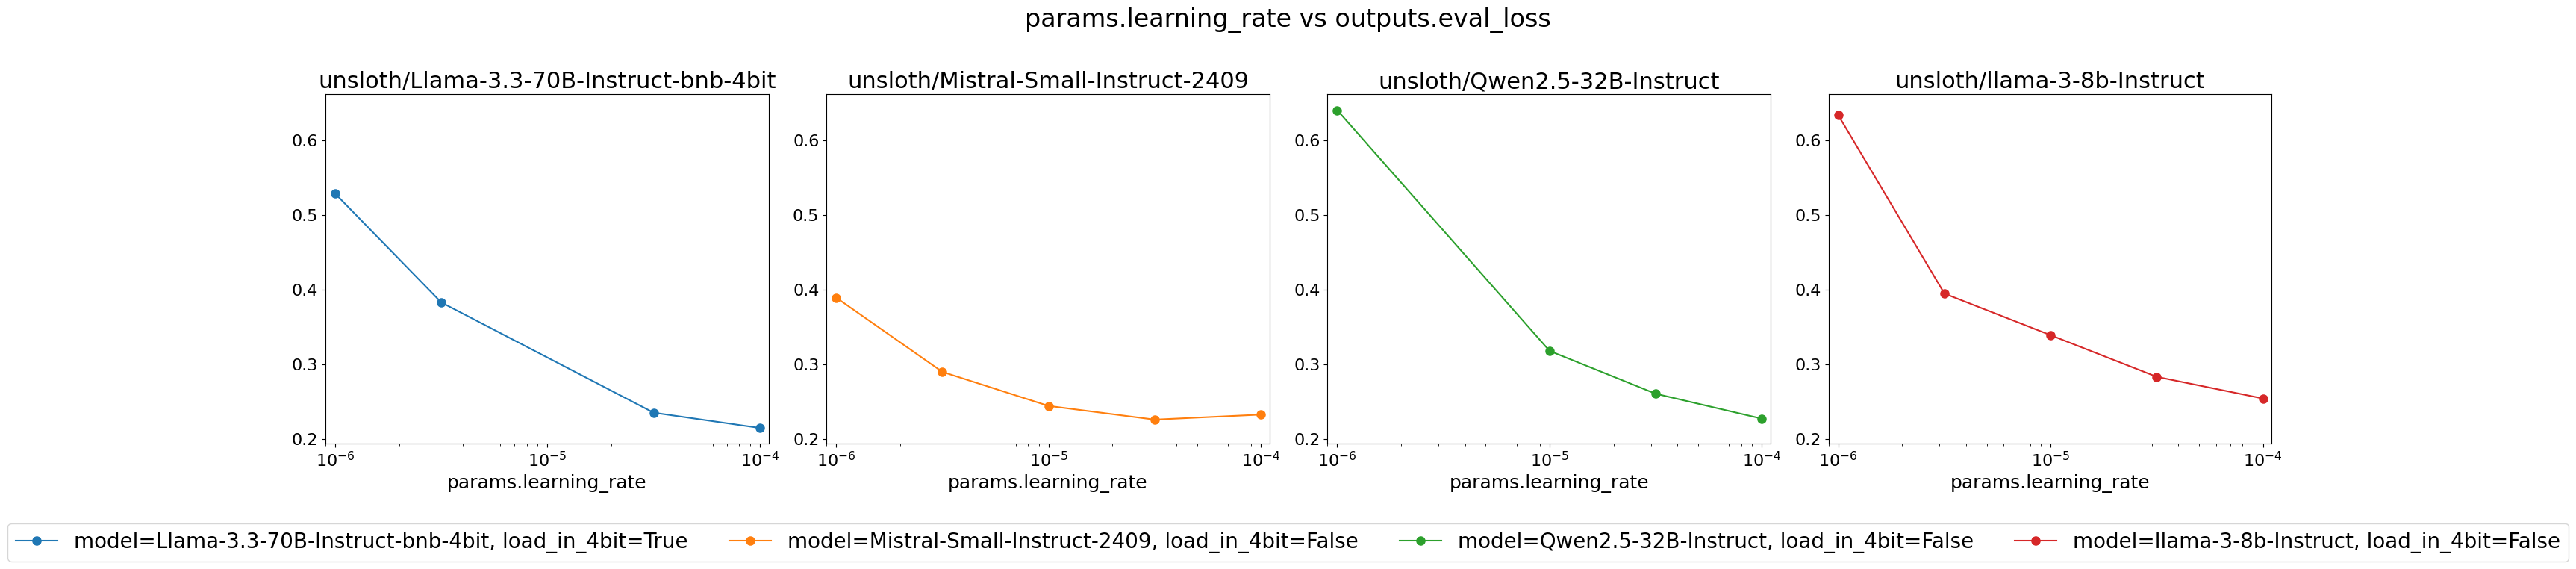

In [13]:
from matplotlib import pyplot as plt
df['params.model'] = df['params.model'].apply(lambda i: i.split('/')[-1])
fig = compare(df, x='params.learning_rate', y='outputs.eval_loss', subplot_rows=None)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def get_last_completed_run(job_id):
    runs = client.runs.list(job_id=job_id)
    runs = [run for run in runs if run['status'] == 'completed']
    return runs[-1]


def get_events_from_run(run):
    events = client.events.list(run_id=run['id'])
    return events


def get_events_from_job(job_id):
    run = get_last_completed_run(job_id)
    return get_events_from_run(run)


def plot_events(jobs, metric, x='step', color='learning_rate', columns='model'):
    models = sorted(set([job['params']['model'] for job in jobs]))
    n_models = len(models)
    
    # Calculate figure width based on number of columns
    width_per_col = 5  # width in inches per subplot
    fig_width = max(width_per_col * n_models, 8)  # minimum width of 8 inches
    
    # Create figure and axes with shared y-axis
    fig, axes = plt.subplots(1, n_models, figsize=(fig_width, 5), sharey=True)
    if n_models == 1:
        axes = [axes]  # Make axes iterable when there's only one subplot
    
    # Get unique color values and create color mapping
    c_values = sorted(set([job['params'][color] for job in jobs]))
    n_colors = len(c_values)
    colors = plt.cm.viridis(np.linspace(0, 1, n_colors))
    colors = {c: colors[i] for i, c in enumerate(c_values)}
    
    # Store lines for legend
    legend_lines = []
    legend_labels = []
    
    # Plot each model
    for i, model in enumerate(models):
        # Get all jobs for this model sorted by color parameter
        jobs_model = [job for job in jobs if job['params']['model'] == model]
        jobs_model = sorted(jobs_model, key=lambda x: x['params'][color])
        
        for job in jobs_model:
            events = get_events_from_job(job['id'])
            df_events = pd.DataFrame([event['data'] for event in events])
            df_events = df_events.dropna(subset=[metric])
            
            line = axes[i].plot(df_events[x], df_events[metric], 
                              color=colors[job['params'][color]], 
                              alpha=0.8)[0]
            
            # Only add to legend if this is the first subplot
            if i == 0:
                legend_lines.append(line)
                legend_labels.append(f"{color}={job['params'][color]}")
        
        # Set title and labels for each subplot
        axes[i].set_title(f"Model: {model}", pad=10)
        axes[i].set_xlabel(x.capitalize())
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # Only add y-label to leftmost subplot
        if i == 0:
            axes[i].set_ylabel(metric.capitalize())
    
    # Add single legend to the figure
    fig.legend(legend_lines, legend_labels, 
              loc='center right', 
              bbox_to_anchor=(0.98, 0.5),
              title=color.replace('_', ' ').title())
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Adjust right margin to accommodate legend
    plt.subplots_adjust(right=0.85)
    
    return fig, axes

# Usage example:
# fig, axes = plot_events(jobs, 'loss')
# plt.show()

1e-6.0
1e-5.5
1e-5.5
1e-5.5
1e-5.0
1e-4.0
1e-6.0
1e-6.0
1e-6.0
1e-5.0
1e-5.0
1e-4.5
1e-4.0
1e-4.5
1e-4.0
1e-4.5
1e-4.0
1e-4.5


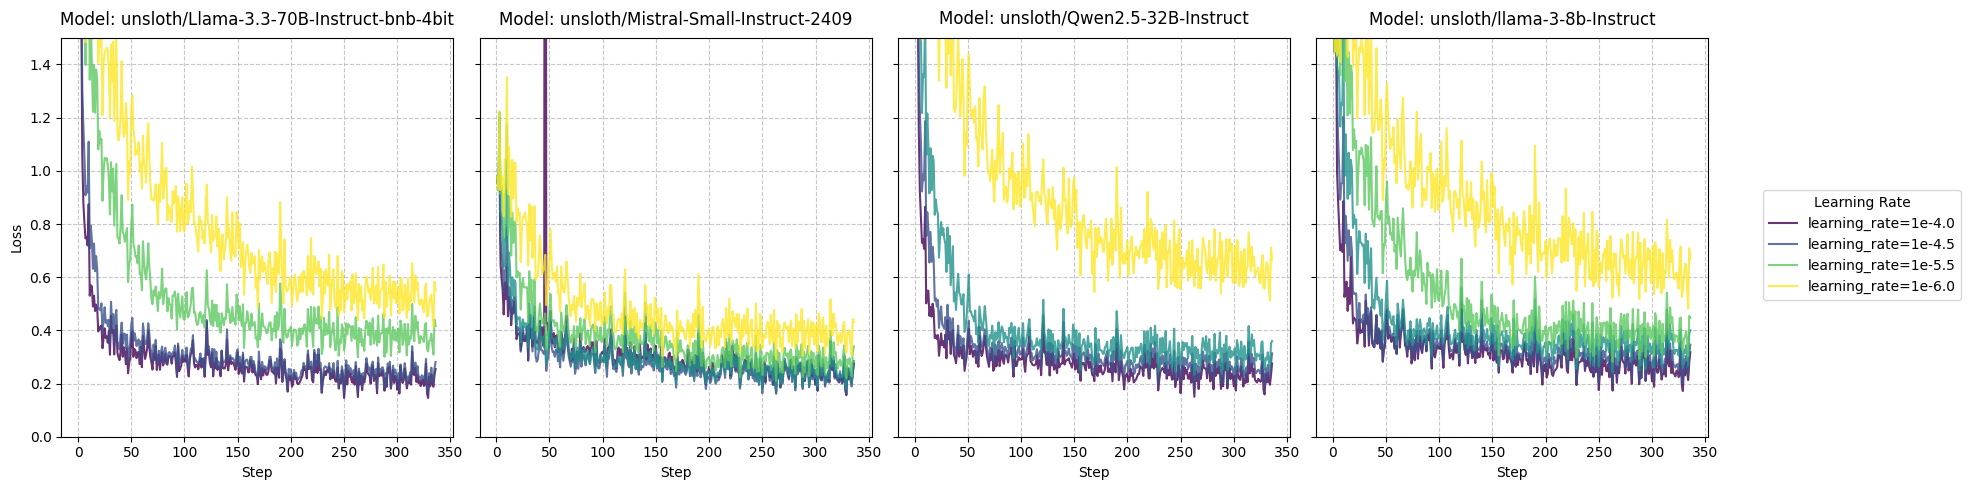

In [22]:
for job in jobs:
    if not isinstance(job['params']['learning_rate'], str):
        job['params']['learning_rate'] = f"1e{np.log10(job['params']['learning_rate'])}"
        print(job['params']['learning_rate'])


fig, axes = plot_events(jobs, 'loss')
axes[0].set_ylim(0, 1.5)
plt.show()